In [12]:
import requests
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import illustris_python as il
from collections.abc import Iterable # for isinstance ... to check if param2 is scalar or array

baseUrl = 'http://www.tng-project.org/api/'
# Make sure you have a TNGTOKEN environment variable set
token = os.getenv("TNGTOKEN")
if token is None:
    raise ValueError("Need to set environment variable TNGTOKEN and relaunch Jupyter...")
headers = {"api-key":token}

def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r

def getsubhalo(subhaloid,simulation='TNG50-1',snapnum=99,parameter=None):
    """Extract subhalo parameters at given snapnum
    Author: Gary Mamon (gam AAT iap.fr)"""
    url = 'http://www.tng-project.org/api/' + simulation + '/snapshots/' + str(snapnum) + '/subhalos/' + str(subhaloid)
    if parameter is None:
        return get(url)
    elif parameter in ["ssfr","sSFR"]:
        return get(url)['sfrinrad']/(1e10*get(url)['massinrad_stars'])
    else:
        return get(url)[parameter]

def ConvertDict(dict,df=False):
    """convert dict to new dict (or pandas dataframe) so that all 2D data become 1D"""
    dictNew = {}
    for k,key in enumerate(dict):
        if k > 0: # skip count
            if isinstance(dict[key][0],np.ndarray):
                keylen2 = len(dict[key][0])
                for i in range(keylen2):
                    key2 = key + str(i)
                    dictNew[key2] = dict[key][:,i]
            else:
                dictNew[key] = dict[key]
    if df:
        return pd.DataFrame.from_dict(dictNew)
    else:
        return dictNew
    
def indices(dict,param,valuemin,valuemax):
    """Convert dict to dataframe    
    returns indices as numpy array
    Author: Gary Mamon (gam AAT iap.fr) and Yuankang Liu (yuankang.liu AAT gmail.com)"""
    df = ConvertDict(dict,df=True)
    return df.index[(df[param]>=valuemin) & (df[param]<=valuemax)].values

def History(subhaloid,param='SFR',param2=None,sim='TNG50-1',treemethod='sublink_mpb',
                snapmin=None,snapmax=99,datafileprefix=None,plot=True,
                xlabel='snapnum',ylabel=None,yscale='log',ylims=None,
                verbose=0,savefig=False,usetex=True,marker=None):
    """Extract and optionally plot evolution of subhalo parameter
    arguments:
        subhaloid
        param=param, where param is one of the subhalo attributes, or shortcuts
            "Mass" (stellar mass within 2 r_h)
            "SFR" (SFR within 2 r_h)
            "sSFR" (sSFR = SFR/Mass_Stars, both within 2 r_h)
        param2=num, where num is the type for Mass (e.g. 4 for Stars)
        snapmax: highest (latest, i.e. base) snapnum (default 99)
        snapmin: lowest (earliest) snapnum (default None last plus one)
        datafileprefix: data file prefix (0 or "auto" for sublink_mpb_[subhaloid], None to extract (default))
        plot: do-plot? [boolean]
        xlabel: x-label
        ylabel: y-label
        yscale: scale of y axis
        ylims: [ymin,ymax]
        savefig: output fil of figure
        usetex: use TeX fonts?
        marker: marker (default None)
    Author: Gary Mamon (gam AAT iap.fr)"""
    
    if datafileprefix is None:
        # extract subhalo URL 
        print("extracting subhalo URL...")
        sub = getsubhalo(subhaloid,simulation=sim,snapnum=snapmax)
        progurl = sub['related']['sublink_progenitor']
        print("progurl=",progurl)
        if progurl is None:
            print("no progenitor for subhalo", subhaloid)
            return
        # extract tree of main progenitor
        print("extracting tree of main progenitor...")
        datafile = get( sub['trees'][treemethod] )
    elif datafileprefix in [0,'a',"auto"]:
        datafile = "sublink_mpb_" + str(subhaloid) + ".hdf5"
    else:
        datafile = datafileprefix + ".hdf5" 
    
    # extract values
    print("extracting parameters from tree in file " + datafile + "...")
    try:
        f = h5py.File(datafile,'r')
    except:
        raise FileNotFoundError(datafile)
    if verbose > 0:
        print("f.keys=",f.keys())
    snapnum = f['SnapNum'][:]
    if snapmin is None:
        snapmin = snapnum[-1]-1
    # for check of ssFR is in parameter name (param)
    substr = "sSFR"
    i = param.index(substr) if substr in param else -1
    if param in ["sSFR","ssfr","SSFR"]: # special treatment for sSFR like param name
        # use 2 R_e aperture
        sfr = f['SubhaloSFRinRad']
        massStars = f['SubhaloMassInRadType']
        massStars = massStars[:,4]*1e10
        y = np.log10(sfr/massStars)
        yscale = 'linear'
        if ylabel is None:
            if usetex:
                ylabel = "\log\,[\mathrm{sSFR}\,(2\,R_\mathrm{e})]\ (\mathrm{yr}^{-1})"
            else:
                ylabel = "log sSFR (2 R_e) [1/yr]"
    elif param in ["sfr",'SFR']: # special treatment for SFR like param name
        # use 2 R_e aperture
        sfr = f['SubhaloSFRinRad']
        y = np.log10(sfr[:,])
        yscale = 'linear'
        if ylabel is None:
            if usetex:
                ylabel = "\log\,[\mathrm{SFR}\,(2\,R_\mathrm{e})]\ (\mathrm{M_\odot\,yr}^{-1})"
            else:
                ylabel = "log SFR (2 R_e) [M_sun/yr]"
    elif param in ["mass","Mass"]: # special treatment for mass like param name
        mass = f['SubhaloMass']
        y = np.log10(1e10 * mass[:])
        yscale = 'linear'
        if ylabel is None:
            if usetex:
                ylabel = "\log\,[\mathrm{mass}_\mathrm{subhalo})]\ (\mathrm{M}_\odot)"
            else:
                ylabel = "log mass (subhalo) [M_sun]"
    elif param in ["mass2Re","Mass2Re"]: # special treatment for mass like param name
        mass = f['SubhaloMassInRadType']
        y = np.log10(1e10 * mass[:,:])
        yscale = 'linear'
        param2 = (0,1,4)
        if ylabel is None:
            if usetex:
                ylabel = "\log\,[\mathrm{mass}\ (2\,R_\mathrm{e})]\ (\mathrm{M}_\odot)"
            else:
                ylabel = "log mass (2 R_e) [M_sun]"
    elif i > 0: # sSFR trick
        sfrvarname = param.replace("sSFR","SFR")
        massvarname = param.replace("sSFR","Mass") + "Type"
        massvarname = massvarname.replace("in","In")
        if verbose > 0:
            print("massvarname=",massvarname)
        massStars = f[massvarname]
        massStars = massStars[:,4]*1e10
        y = f[sfrvarname]/massStars
        if ylabel is None:
            if usetex:
                ylabel = "sSFR\ (2\,R_\mathrm{e}) [yr^{-1}]"
            else:
                ylabel = "sSFR (2 R_e) [1/yr]"           
    else: # use given param
        y = f[param][:]
    if param2 is not None: # particle type if given
        y = y[:,param2]
    if verbose > 0:
        print("snapnum=",snapnum)
        print("y = ",y)

    # plot
    if not plot:
        return y

    print("plotting...")
    if yscale == 'log':
        ymin = np.min(y[y>0])
        ymin4plot = 10**(np.floor(np.log10(ymin)))
        y2 = np.where(y<=0,ymin4plot,y)
        plt.ylim = (0.5*ymin4plot,)
    else:
        y2 = y
    if ylabel is None:
        ylabel = param
        usetex = False
    # limit types to Dark matter, gas, and stars
    colors = ('k','g','brown','orange','b','purple')
    labels = ('dark matter','gas','type 2','tracers','stars','black holes')
    # check if Type is in parameter name (param)
    substr = "Type"
    i = param.index(substr) if substr in param else -1
    if i >= 0: # Type is in parameter name
        legend = True
        if param2 is not None:
            if isinstance(param2,Iterable): # param2 is a list or tuple or array
                for i, par2 in enumerate(param2):
                    plt.plot(snapnum,y2[:,i],label=labels[par2],
                             color=colors[par2],marker=marker)
            else: # param2 is a scalar
                par2 = param2
                plt.plot(snapnum,y2[:],color=colors[par2],marker=marker)
                legend = False
        else: # param2 is not given, assume types are dark matter, gas, and stars
            for i in [0,1,4]:
                plt.plot(snapnum,y2[:,i],label=labels[i],
                         color=colors[i],marker=marker)
        if legend:
            plt.legend()
    else: # Type is not in parameter name
        plt.plot(snapnum,y2,marker=marker)
        if param in ["mass","Mass"]:
            plt.legend()
    if usetex: # assume LaTeX labels
        xlabel = '$\mathrm{' + xlabel + '}$'
        ylabel = '$' + ylabel + '$'
    if verbose > 0:
        print("ylabel=",ylabel)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.yscale(yscale)
    if snapmax is None:
        snapmax = 99
    plt.xlim(snapmin,snapmax+1)
    if ylims is not None:
        plt.ylim(ylims)
#     plt.tight_layout(w_pad=0.5, h_pad=1)
    plt.title(sim + "  subhalo " + str(subhaloid), fontsize=18)
    if savefig is not False: # save figure to PDF file
        if savefig in [0,'auto']: # automatic file prefix
            savefig = param + "vsSnapnum_" + str(subhaloid)
        print("plotting into file",savefig + ".pdf")
        plt.savefig(savefig + ".pdf",bbox_inches='tight',pad_inches=0.25)
    return y
    
def FitMainSequence(subhalodict,lssfrThreshold=-12,maxlMass=10,plot=False):
    lmass,lsfr = 10+np.log10(subhalodict['SubhaloMassInRadType'][:,4]),np.log10(subhalodict['SubhaloSFRinRad'])
    lssfr = lsfr - lmass
    lmbins = np.linspace(8,12,9)
    dlm = lmbins[1]-lmbins[0]
    lmbins = lmbins + dlm/2 # so that first bin is from 8 to 8.5
    lssfrMed = np.zeros(len(lmbins))
    lssfrMean = np.zeros(len(lmbins))
    # sfrThreshold = 10**lsfr_Threshold
    for i, lmb in enumerate(lmbins):
        # select by mass and above SFR threshold 
        cond = ((np.abs(lmass-lmb)<dlm/2) & (lssfr > lssfrThreshold))
        lmasstmp,lssfrtmp = lmass[cond],lssfr[cond]
        lssfrMed[i] = np.median(lssfrtmp)
        lssfrMean[i] = lssfrtmp.mean()
    lssfrMode = 3*lssfrMed - 2*lssfrMean
    
    # fit line
    
    coeffsMedian = np.polyfit(lmbins[lmbins<maxlMass],lssfrMed[lmbins<maxlMass],1)
    coeffsMode = np.polyfit(lmbins[lmbins<maxlMass],lssfrMode[lmbins<maxlMass],1)
    
    if plot:
        plt.scatter(lmass,lssfr,s=1)
        plt.scatter(lmbins,lssfrMed,label='median')
        plt.scatter(lmbins,lssfrMode,label='mode')
        plt.plot(lmbins,lmbins*coeffsMedian[0]+coeffsMedian[1],label='median')
        plt.plot(lmbins,lmbins*coeffsMode[0]+coeffsMode[1],label='mode')
        plt.xlim(8,12)
        plt.ylim(-13)
        plt.xlabel('$\log\,(M_\star/\mathrm{M}_\odot)$')
        plt.ylabel('$\log\,(\mathrm{sSFR}/\mathrm{yr}^{-1})$')
        plt.legend()
        plt.savefig(plot + '.pdf')
        
    return coeffsMedian, coeffsMode

def FitMainSequence2(subhalodict,lssfrThreshold=-12,maxlMass=10,minlMass=8,plot=False):
    lmass,lsfr = 10+np.log10(subhalodict['SubhaloMassInRadType'][:,4]),np.log10(subhalodict['SubhaloSFRinRad'])
    lssfr = lsfr - lmass
    lmbins = np.linspace(8,12,9)
    dlm = lmbins[1]-lmbins[0]
    lmbins = lmbins + dlm/2 # so that first bin is from 8 to 8.5
    lssfrMed = np.zeros(len(lmbins))
    lssfrMean = np.zeros(len(lmbins))
    # sfrThreshold = 10**lsfr_Threshold
    for i, lmb in enumerate(lmbins):
        # select by mass and above SFR threshold 
        cond = ((np.abs(lmass-lmb)<dlm/2) & (lssfr > lssfrThreshold))
        lmasstmp,lssfrtmp = lmass[cond],lssfr[cond]
        lssfrMed[i] = np.median(lssfrtmp)
        lssfrMean[i] = lssfrtmp.mean()
    lssfrMode = 3*lssfrMed - 2*lssfrMean
    
    # fit line
    
    coeffsMedian = np.polyfit(lmbins[lmbins<maxlMass],lssfrMed[lmbins<maxlMass],1)
    coeffsMode = np.polyfit(lmbins[lmbins<maxlMass],lssfrMode[lmbins<maxlMass],1)

    for j in range(3):
        print("iteration",j+1)
        # residuals

        dlssfr = lssfr - (coeffsMode[0]*lmass + coeffsMode[1])
        lmbins2 = np.linspace(8,maxlMass,int(1+(maxlMass-8)*2))
        sigResiduals = np.zeros(len(lmbins2))
        for i, lmb in enumerate(lmbins2):
            # select by mass 
            cond = ((np.abs(lmass-lmb)<dlm/2) & (dlssfr > -10))
            dlssfrtmp = dlssfr[cond]
            sigResiduals[i] = np.std(dlssfrtmp)

        # fit line to the standard deviation of the residuals 

        print("lmbins2 = ",lmbins2)
        print("sigResiduals=",sigResiduals)
        plt.scatter(lmbins2,sigResiduals)
        coeffsSTD = np.polyfit(lmbins2,sigResiduals,1)

        # remove points that are beyond 3 sigma

#         cond = np.abs(lssfr - lssfrMode) < 3*(coeffsSTD[0]*lmass+coeffsSTD[1])

#         lmass = lmass[cond]
#         lssfr = lssfr[cond]
        lssfrMed = np.zeros(len(lmbins))
        lssfrMean = np.zeros(len(lmbins))
        # sfrThreshold = 10**lsfr_Threshold
        for i, lmb in enumerate(lmbins):
            # select by mass and above SFR threshold 
            cond = ((np.abs(lmass-lmb)<dlm/2) & (np.abs(lssfr - lssfrMode[i]) < 3*(coeffsSTD[0]*lmass+coeffsSTD[1])))
            lmasstmp,lssfrtmp = lmass[cond],lssfr[cond]
            print("lmass=",lmb,"N=",len(lmasstmp))
            lssfrMed[i] = np.median(lssfrtmp)
            lssfrMean[i] = lssfrtmp.mean()
        lssfrMode = 3*lssfrMed - 2*lssfrMean

        # fit line

        coeffsMedian = np.polyfit(lmbins[lmbins<maxlMass],lssfrMed[lmbins<maxlMass],1)
        coeffsMode = np.polyfit(lmbins[lmbins<maxlMass],lssfrMode[lmbins<maxlMass],1)
        print("Mode: slope=",coeffsMode[0],"value at 10=",coeffsMode[0]*10+coeffsMode[1])
        
    if plot:
        print("plotting...")
        plt.scatter(lmass,lssfr,s=1)
        plt.scatter(lmbins,lssfrMed,label='median')
        plt.scatter(lmbins,lssfrMode,label='mode')
        plt.plot(lmbins,lmbins*coeffsMedian[0]+coeffsMedian[1],label='median')
        plt.plot(lmbins,lmbins*coeffsMode[0]+coeffsMode[1],label='mode')
        plt.xlim(8,12)
        plt.ylim(-13)
        plt.xlabel('$\log\,(M_\star/\mathrm{M}_\odot)$')
        plt.ylabel('$\log\,(\mathrm{sSFR}/\mathrm{yr}^{-1})$')
        plt.legend()
        if plot == 'auto':
            plt.show()
        else:
            plt.savefig(plot + '.pdf')        
    return coeffsMode

# Extract subhalos with criteria

In [52]:
basepath = "/Users/gam/SIMS/TNG/TNG50/output"
tmp = il.groupcat.loadSubhalos(basePath=basepath,snapNum=99)
df = ConvertDict(tmp,df=True)

SubhaloBHMass  SubhaloBHMdot  SubhaloBfldDisk  SubhaloBfldHalo  \
0             0.579029   1.852354e-04         2.008474         0.172786   
1             0.054223   1.516171e-05         0.068316         0.069231   
2             0.029711   2.138259e-06         0.134068         0.303128   
3             0.020092   7.053461e-06         0.065826         0.120497   
4             0.019615   3.058788e-07         0.817195         0.807718   
...                ...            ...              ...              ...   
5688108       0.000000   0.000000e+00         0.000000         0.000000   
5688109       0.000000   0.000000e+00         0.000000         0.000000   
5688110       0.000000   0.000000e+00         0.000000         0.000000   
5688111       0.000000   0.000000e+00         0.000000         0.000000   
5688112       0.000000   0.000000e+00         0.000000         0.000000   

           SubhaloCM0    SubhaloCM1    SubhaloCM2  SubhaloFlag  \
0         7300.426270  24514.015625  21300.208984         True   
1         6812.355469  24896.800781  21219.810547         True   
2         6780.131348  23867.488281  21088.685547         True   
3         7322.278809  25125.027344  20773.980469         True   
4         7635.023438  24392.828125  21199.900391         True   
...               ...           ...           ...          ...   
5688108  34608.597656  20437.330078   3370.657471         True   
5688109  34020.156250   9915.755859  18063.207031         True   
5688110  30996.972656  10243.407227  32578.519531         True   
5688111  33110.003906  24574.789062   6742.690918         True   
5688112  31732.861328  23892.533203   6156.668457         True   

         SubhaloGasMetalFractions0  SubhaloGasMetalFractions1  ...  \
0                         0.740028                   0.250430  ...   
1                         0.680867                   0.277670  ...   
2                         0.697962                   0.271066  ...   
3                         0.680394                   0.276450  ...   
4                         0.698260                   0.268986  ...   
...                            ...                        ...  ...   
5688108                   0.000000                   0.000000  ...   
5688109                   0.000000                   0.000000  ...   
5688110                   0.000000                   0.000000  ...   
5688111                   0.000000                   0.000000  ...   
5688112                   0.000000                   0.000000  ...   

         SubhaloStellarPhotometrics7  SubhaloStellarPhotometricsMassInRad  \
0                      -2.672215e+01                           249.120911   
1                      -2.373738e+01                            21.635269   
2                      -2.317702e+01                             9.841280   
3                      -2.221618e+01                             5.365546   
4                      -2.216082e+01                             5.449239   
...                              ...                                  ...   
5688108                 1.000000e+37                             0.000000   
5688109                 1.000000e+37                             0.000000   
5688110                 1.000000e+37                             0.000000   
5688111                 1.000000e+37                             0.000000   
5688112                 1.000000e+37                             0.000000   

         SubhaloStellarPhotometricsRad  SubhaloVel0  SubhaloVel1  SubhaloVel2  \
0                            47.998219    14.129664     2.131469   -39.024796   
1                            13.419003   539.075134  -504.031250  -151.045761   
2                             9.637778   266.607758   547.416016   838.099792   
3                             5.830610  -235.743912  -496.904572   -93.513161   
4                             5.833010   211.173889  -703.205444  -483.650330   
...                                ...          ...          ..

In [72]:
idx = indices(tmp,'SubhaloMass',0.5,1)

converting to pandas dataframe...
extracting ...


In [73]:
idx

array([    72,     74,     76, ..., 937089, 937139, 937427])

# Extract subhalo

In [15]:
getsubhalo(300907)

{'snap': 99,
 'id': 300907,
 'bhmdot': 0.0,
 'cm_x': 15091.6,
 'cm_y': 4803.86,
 'cm_z': 33030.4,
 'gasmetallicity': 0.0665398,
 'gasmetallicityhalfrad': 0.0829221,
 'gasmetallicitymaxrad': 0.0845663,
 'gasmetallicitysfr': 0.0485123,
 'gasmetallicitysfrweighted': 0.0779427,
 'pos_x': 15091.6,
 'pos_y': 4803.85,
 'pos_z': 33030.4,
 'halfmassrad': 0.1997,
 'halfmassrad_gas': 0.4404,
 'halfmassrad_dm': 0.8531,
 'halfmassrad_stars': 0.1921,
 'halfmassrad_bhs': 0.0,
 'len': 343476,
 'len_gas': 11806,
 'len_dm': 177,
 'len_stars': 331493,
 'len_bhs': 0,
 'mass': 1.73177,
 'mass_gas': 0.075886,
 'mass_dm': 0.00544,
 'mass_stars': 1.65044,
 'mass_bhs': 0.0,
 'massinhalfrad': 0.837447,
 'massinhalfrad_gas': 0.01217,
 'massinhalfrad_dm': 6.1e-05,
 'massinhalfrad_stars': 0.825216,
 'massinhalfrad_bhs': 0.0,
 'massinmaxrad': 0.782927,
 'massinmaxrad_gas': 0.010753,
 'massinmaxrad_dm': 0.0,
 'massinmaxrad_stars': 0.772174,
 'massinmaxrad_bhs': 0.0,
 'massinrad': 1.22397,
 'massinrad_gas': 0.033717,

In [16]:
getsubhalo(300907,parameter='massinrad_stars')

1.18976

In [17]:
getsubhalo(300907,parameter='sfrinrad')

10.0564

In [18]:
getsubhalo(300907,parameter='ssfr')

8.452461000537923e-10

extracting subhalo URL...
extracting tree of main progenitor...
extracting parameters from tree in file sublink_mpb_300907.hdf5...
plotting...


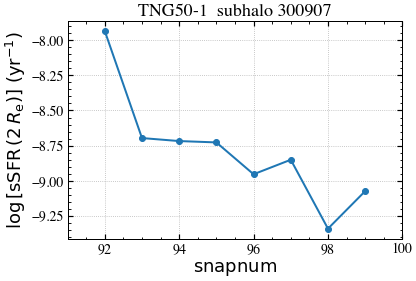

In [56]:
History(300907,param='ssfr',yscale='log',datafileprefix=None,verbose=0,marker='o',snapmin=None)

extracting subhalo URL...
extracting tree of main progenitor...
extracting parameters from tree in file sublink_mpb_300907.hdf5...
plotting...


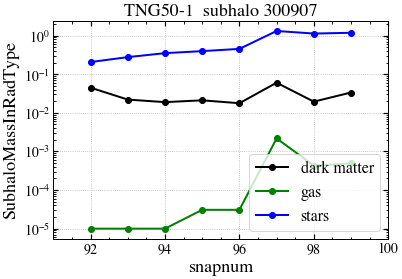

In [6]:
History(300907,param='SubhaloMassInRadType',yscale='log',datafileprefix=None,verbose=0,marker='o')

extracting subhalo URL...
extracting tree of main progenitor...
extracting parameters from tree in file sublink_mpb_300908.hdf5...
plotting...


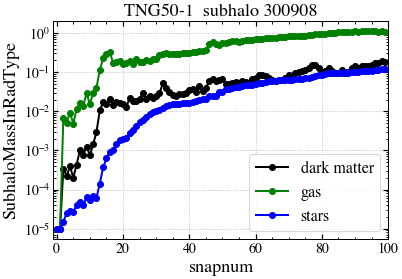

In [7]:
History(300908,param='SubhaloMassInRadType',yscale='log',datafileprefix=None,verbose=0,marker='o')

extracting subhalo URL...
extracting tree of main progenitor...
extracting parameters from tree in file sublink_mpb_300909.hdf5...
plotting...


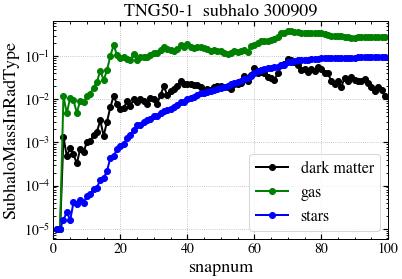

In [8]:
History(300909,param='SubhaloMassInRadType',yscale='log',datafileprefix=None,verbose=0,marker='o')

extracting subhalo URL...
extracting tree of main progenitor...
extracting parameters from tree in file sublink_mpb_300906.hdf5...
plotting...


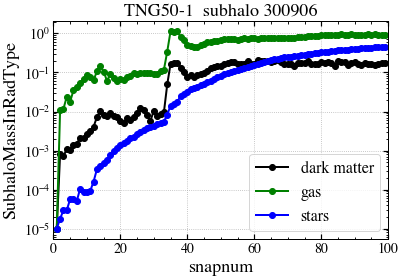

In [10]:
History(300906,param='SubhaloMassInRadType',yscale='log',datafileprefix=None,verbose=0,marker='o')

extracting parameters from tree in file sublink_mpb_300906.hdf5...
plotting...


/Users/gam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in true_divide


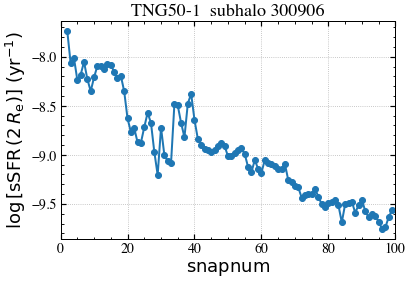

In [11]:
History(300906,param='sSFR',yscale='log',datafileprefix=0,verbose=0,marker='o')

extracting parameters from tree in file sublink_mpb_300906.hdf5...
plotting...


/Users/gam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: divide by zero encountered in log10


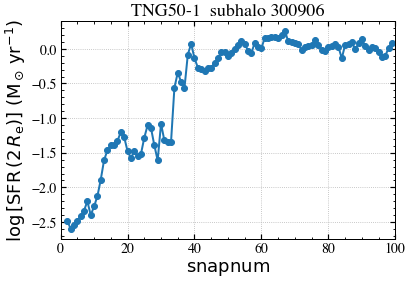

In [12]:
History(300906,param='SFR',yscale='log',datafileprefix=0,verbose=0,marker='o')

extracting parameters from tree in file sublink_mpb_300909.hdf5...
plotting...


/Users/gam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in true_divide


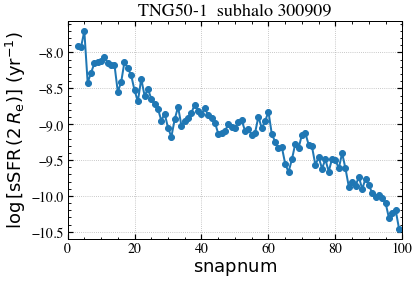

In [9]:
History(300909,param='sSFR',yscale='log',datafileprefix=0,verbose=0,marker='o')

extracting subhalo URL...
extracting tree of main progenitor...
extracting parameters from tree in file sublink_mpb_0.hdf5...
plotting...


/Users/gam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in true_divide


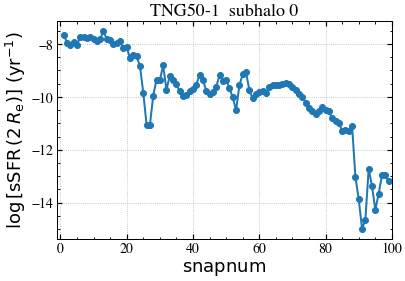

In [13]:
History(0,param='sSFR',yscale='log',datafileprefix=None,verbose=0,marker='o')

In [32]:
History(100,param='sSFR',yscale='log',datafileprefix=None,verbose=0,marker='o')

extracting subhalo URL...
progurl= None
no progenitor for subhalo 100


extracting parameters from tree in file sublink_mpb_0.hdf5...
plotting...


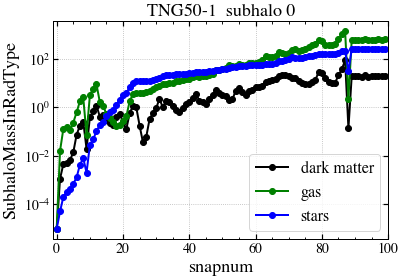

In [14]:
History(0,param='SubhaloMassInRadType',yscale='log',datafileprefix=0,verbose=0,marker='o')

In [4]:
y = History(2682,param='SubhaloMassInRadType',yscale='log',datafileprefix=0,verbose=0,marker='o',plot=False)

extracting parameters from tree in file sublink_mpb_2682.hdf5...


extracting parameters from tree in file sublink_mpb_2682.hdf5...
plotting...


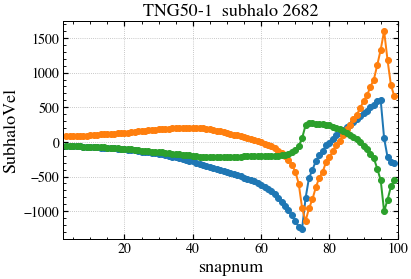

In [8]:
y = History(2682,param='SubhaloVel',yscale='linear',datafileprefix=0,verbose=0,marker='o')

In [6]:
getsubhalo(2682)

{'snap': 99,
 'id': 2682,
 'bhmdot': 0.0,
 'cm_x': 7306.74,
 'cm_y': 24959.5,
 'cm_z': 21078.5,
 'gasmetallicity': 0.0,
 'gasmetallicityhalfrad': 0.0,
 'gasmetallicitymaxrad': 0.0,
 'gasmetallicitysfr': 0.0,
 'gasmetallicitysfrweighted': 0.0,
 'pos_x': 7306.48,
 'pos_y': 24959.7,
 'pos_z': 21078.6,
 'halfmassrad': 2.7516,
 'halfmassrad_gas': 0.0,
 'halfmassrad_dm': 2.7516,
 'halfmassrad_stars': 0.0,
 'halfmassrad_bhs': 0.0,
 'len': 1110,
 'len_gas': 0,
 'len_dm': 1110,
 'len_stars': 0,
 'len_bhs': 0,
 'mass': 0.034118,
 'mass_gas': 0.0,
 'mass_dm': 0.034118,
 'mass_stars': 0.0,
 'mass_bhs': 0.0,
 'massinhalfrad': 0.0,
 'massinhalfrad_gas': 0.0,
 'massinhalfrad_dm': 0.0,
 'massinhalfrad_stars': 0.0,
 'massinhalfrad_bhs': 0.0,
 'massinmaxrad': 0.016598,
 'massinmaxrad_gas': 0.0,
 'massinmaxrad_dm': 0.016598,
 'massinmaxrad_stars': 0.0,
 'massinmaxrad_bhs': 0.0,
 'massinrad': 0.0,
 'massinrad_gas': 0.0,
 'massinrad_dm': 0.0,
 'massinrad_stars': 0.0,
 'massinrad_bhs': 0.0,
 'sfr': 0.0,
 's

In [20]:
np.logspace(1,4,13).astype(int)

array([   10,    17,    31,    56,   100,   177,   316,   562,  1000,
        1778,  3162,  5623, 10000])

subhalo 100
extracting subhalo URL...
progurl= None
no progenitor for subhalo 100
subhalo 138
extracting subhalo URL...
progurl= http://www.tng-project.org/api/TNG50-1/snapshots/98/subhalos/133/
extracting tree of main progenitor...
extracting parameters from tree in file sublink_mpb_138.hdf5...
plotting...


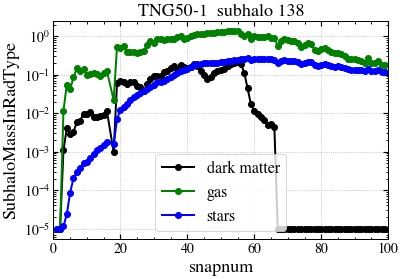

extracting parameters from tree in file sublink_mpb_138.hdf5...
plotting...


/Users/gam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide
/Users/gam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in log10


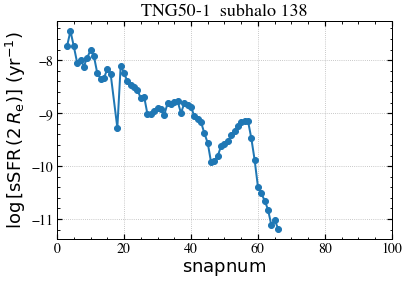

subhalo 193
extracting subhalo URL...
progurl= http://www.tng-project.org/api/TNG50-1/snapshots/98/subhalos/199/
extracting tree of main progenitor...
extracting parameters from tree in file sublink_mpb_193.hdf5...
plotting...


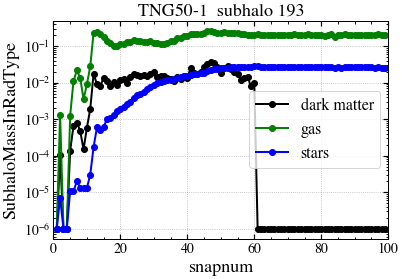

extracting parameters from tree in file sublink_mpb_193.hdf5...
plotting...


/Users/gam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide
/Users/gam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in log10


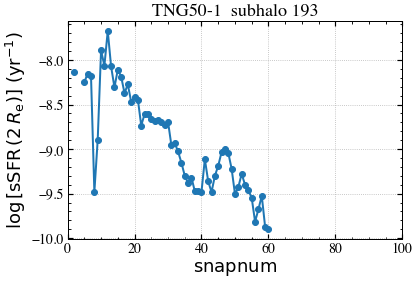

subhalo 268
extracting subhalo URL...
progurl= http://www.tng-project.org/api/TNG50-1/snapshots/98/subhalos/269/
extracting tree of main progenitor...
extracting parameters from tree in file sublink_mpb_268.hdf5...
plotting...


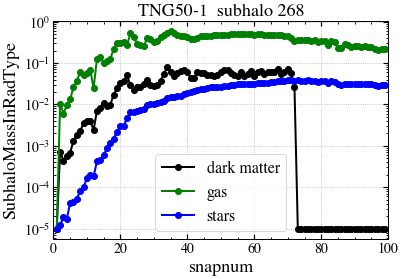

extracting parameters from tree in file sublink_mpb_268.hdf5...
plotting...


/Users/gam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide
/Users/gam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in log10


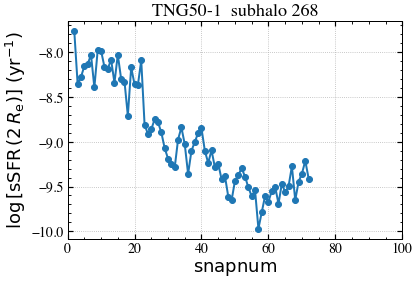

subhalo 372
extracting subhalo URL...
progurl= None
no progenitor for subhalo 372
subhalo 517
extracting subhalo URL...
progurl= http://www.tng-project.org/api/TNG50-1/snapshots/98/subhalos/541/
extracting tree of main progenitor...
extracting parameters from tree in file sublink_mpb_517.hdf5...
plotting...


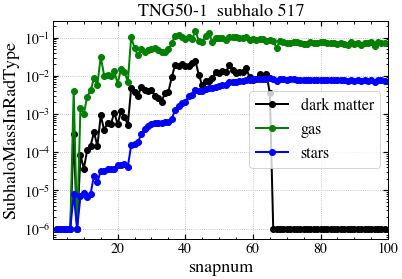

extracting parameters from tree in file sublink_mpb_517.hdf5...
plotting...


/Users/gam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide
/Users/gam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in log10


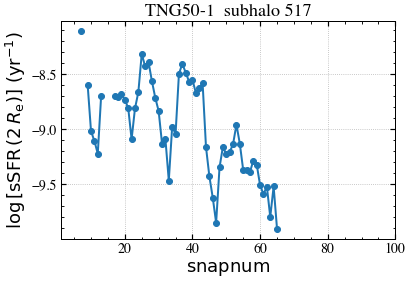

subhalo 719
extracting subhalo URL...
progurl= http://www.tng-project.org/api/TNG50-1/snapshots/98/subhalos/845/
extracting tree of main progenitor...
extracting parameters from tree in file sublink_mpb_719.hdf5...
plotting...


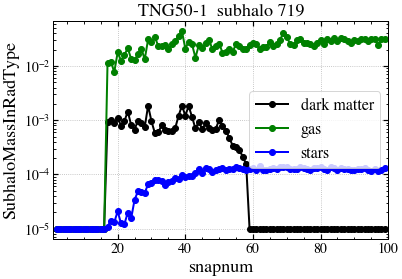

extracting parameters from tree in file sublink_mpb_719.hdf5...
plotting...


/Users/gam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide
/Users/gam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in log10


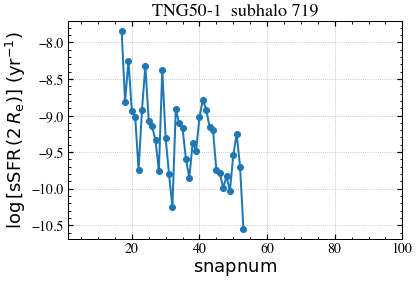

subhalo 1000
extracting subhalo URL...
progurl= http://www.tng-project.org/api/TNG50-1/snapshots/98/subhalos/1043/
extracting tree of main progenitor...
extracting parameters from tree in file sublink_mpb_1000.hdf5...
plotting...


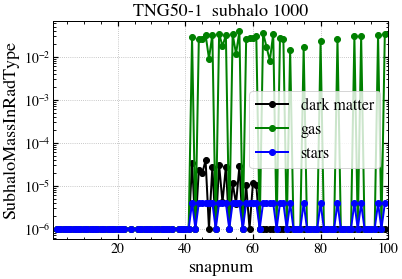

extracting parameters from tree in file sublink_mpb_1000.hdf5...
plotting...


/Users/gam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide
/Users/gam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in log10


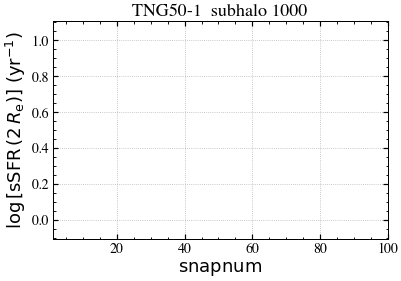

subhalo 1389
extracting subhalo URL...
progurl= http://www.tng-project.org/api/TNG50-1/snapshots/98/subhalos/1611/
extracting tree of main progenitor...
extracting parameters from tree in file sublink_mpb_1389.hdf5...
plotting...


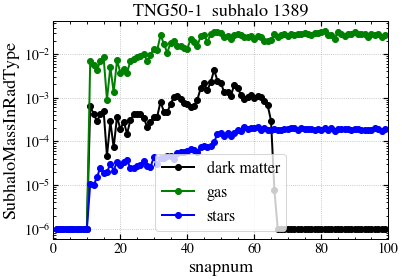

extracting parameters from tree in file sublink_mpb_1389.hdf5...
plotting...


/Users/gam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide
/Users/gam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in log10


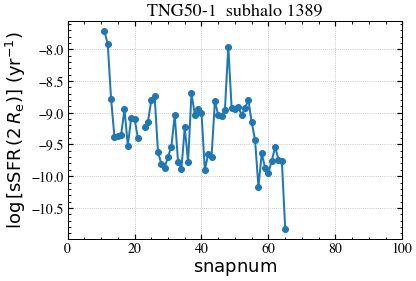

subhalo 1930
extracting subhalo URL...
progurl= http://www.tng-project.org/api/TNG50-1/snapshots/98/subhalos/1836/
extracting tree of main progenitor...
extracting parameters from tree in file sublink_mpb_1930.hdf5...
plotting...


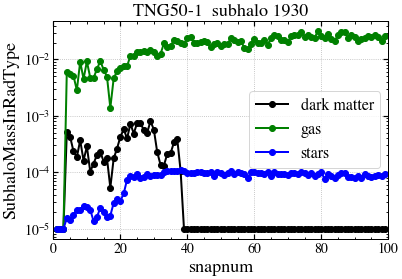

extracting parameters from tree in file sublink_mpb_1930.hdf5...
plotting...


/Users/gam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide
/Users/gam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in log10


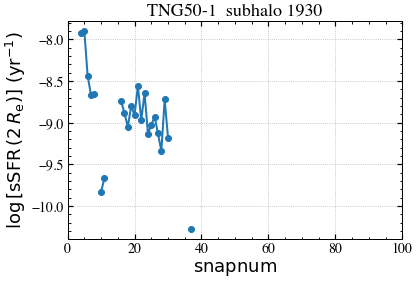

subhalo 2682
extracting subhalo URL...
progurl= http://www.tng-project.org/api/TNG50-1/snapshots/98/subhalos/2662/
extracting tree of main progenitor...
extracting parameters from tree in file sublink_mpb_2682.hdf5...
plotting...


ValueError: zero-size array to reduction operation minimum which has no identity

In [2]:
for i in np.logspace(2,4,15).astype(int):
    print("subhalo",int(i))
    out = History(int(i),param='SubhaloMassInRadType',yscale='log',datafileprefix=None,verbose=0,marker='o')
    if out is None:
        continue
    plt.show()
    History(int(i),param='sSFR',yscale='log',datafileprefix=0,verbose=0,marker='o')
    plt.show()

In [22]:
getsubhalo(100,simulation='TNG50-1',snapnum=99)

{'snap': 99,
 'id': 100,
 'bhmdot': 0.0,
 'cm_x': 7258.25,
 'cm_y': 24572.3,
 'cm_z': 21321.7,
 'gasmetallicity': 0.0,
 'gasmetallicityhalfrad': 0.0,
 'gasmetallicitymaxrad': 0.0,
 'gasmetallicitysfr': 0.0,
 'gasmetallicitysfrweighted': 0.0,
 'pos_x': 7258.25,
 'pos_y': 24572.3,
 'pos_z': 21321.7,
 'halfmassrad': 0.2097,
 'halfmassrad_gas': 0.0,
 'halfmassrad_dm': 0.0,
 'halfmassrad_stars': 0.2097,
 'halfmassrad_bhs': 0.0,
 'len': 89451,
 'len_gas': 0,
 'len_dm': 0,
 'len_stars': 89451,
 'len_bhs': 0,
 'mass': 0.366017,
 'mass_gas': 0.0,
 'mass_dm': 0.0,
 'mass_stars': 0.366017,
 'mass_bhs': 0.0,
 'massinhalfrad': 0.183007,
 'massinhalfrad_gas': 0.0,
 'massinhalfrad_dm': 0.0,
 'massinhalfrad_stars': 0.183007,
 'massinhalfrad_bhs': 0.0,
 'massinmaxrad': 0.255502,
 'massinmaxrad_gas': 0.0,
 'massinmaxrad_dm': 0.0,
 'massinmaxrad_stars': 0.255502,
 'massinmaxrad_bhs': 0.0,
 'massinrad': 0.333081,
 'massinrad_gas': 0.0,
 'massinrad_dm': 0.0,
 'massinrad_stars': 0.333081,
 'massinrad_bhs': 

In [26]:
getsubhalo(0,simulation='TNG50-1',snapnum=99)

{'snap': 99,
 'id': 0,
 'bhmdot': 0.000185235,
 'cm_x': 7300.43,
 'cm_y': 24514.0,
 'cm_z': 21300.2,
 'gasmetallicity': 0.00954238,
 'gasmetallicityhalfrad': 0.011177,
 'gasmetallicitymaxrad': 0.0,
 'gasmetallicitysfr': 0.00758403,
 'gasmetallicitysfrweighted': 0.00803236,
 'pos_x': 7307.24,
 'pos_y': 24550.4,
 'pos_z': 21302.6,
 'halfmassrad': 362.23,
 'halfmassrad_gas': 383.195,
 'halfmassrad_dm': 371.711,
 'halfmassrad_stars': 29.2812,
 'halfmassrad_bhs': 0.0,
 'len': 718577369,
 'len_gas': 254750400,
 'len_dm': 369615124,
 'len_stars': 94211842,
 'len_bhs': 3,
 'mass': 13289.6,
 'mass_gas': 1559.96,
 'mass_dm': 11360.8,
 'mass_stars': 368.293,
 'mass_bhs': 0.579029,
 'massinhalfrad': 407.339,
 'massinhalfrad_gas': 3.09503,
 'massinhalfrad_dm': 219.518,
 'massinhalfrad_stars': 184.146,
 'massinhalfrad_bhs': 0.578949,
 'massinmaxrad': 0.001185,
 'massinmaxrad_gas': 0.0,
 'massinmaxrad_dm': 3.1e-05,
 'massinmaxrad_stars': 0.001154,
 'massinmaxrad_bhs': 0.0,
 'massinrad': 894.026,
 'ma